In [2]:
using_colab = True

In [3]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-te9nih5u
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-te9nih5u
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2025-06-14 17:18:42--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.6’

dog

In [4]:
pip install torch torchvision segment-anything shapely scikit-learn matplotlib opencv-python

In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import numpy as np
import cv2
from segment_anything import sam_model_registry, SamPredictor
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import random
import matplotlib.pyplot as plt

# **Exemple PIE implémentation sur 1 image**

Voici une première version du PIE, testée sur une seule image.

Actuellement, l’EAC détecte principalement les oreilles du chien ainsi qu’une partie de la gamelle, qui semblent être les concepts les plus importants. Mais, je pense que ce résultat peut être nettement amélioré. Par manque de ressources, j’ai pas pu tester autant de coalitions que dans l’article original (1 000 contre 50 000), ce qui limite la qualité des explications générées.

Pour reproduire la suite du papier, il faut retrouver les résultats de faithfulness, understability et ablation study.
Pour ceci, il faudrait :
- Obtenir de meilleurs résultats explicatifs sur une image individuelle.

- Implémenter un code d’évaluation de l’AUC via les méthodes d’insertion et de suppression (insertion/deletion scheme).

- Évaluer le modèle sur un ensemble plus large d’images provenant d’ImageNet et COCO.

- Mesurer la compréhensibilité des masques générés auprès de 6 annotateurs humains.

- Noter et analyser le temps de traitement pour chaque étape.

**Phase 1 : Concept Discovery**

Etape 1-2 : Charger l'image et la segmenter avec SAM

In [6]:
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

mkdir: cannot create directory ‘images’: File exists
--2025-06-14 17:19:15--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99846 (98K) [image/jpeg]
Saving to: ‘images/dog.jpg.7’

dog.jpg.7           100%[===================>]  97.51K  --.-KB/s    in 0.02s   

2025-06-14 17:19:15 (5.01 MB/s) - ‘images/dog.jpg.7’ saved [99846/99846]

--2025-06-14 17:19:15--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.189.108, 3.163.189.14, 3.163.189.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.163.189.108|:443... connected.
HTTP request sent, awaiting response

array([[[ 73,  51,  30],
        [ 73,  51,  30],
        [ 73,  51,  30],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[ 73,  51,  30],
        [ 73,  51,  30],
        [ 73,  51,  28],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[ 73,  51,  30],
        [ 73,  51,  28],
        [ 73,  51,  28],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       ...,

       [[140, 142, 154],
        [134, 133, 147],
        [134, 133, 149],
        ...,
        [139, 142, 151],
        [141, 144, 153],
        [140, 143, 152]],

       [[135, 135, 147],
        [132, 131, 145],
        [137, 139, 154],
        ...,
        [139, 142, 151],
        [140, 143, 152],
        [139, 142, 151]],

       [[130, 132, 144],
        [131, 133, 145],
        [142, 144, 157],
        ...,
        [139, 142, 151],
        [140, 143, 152],
        [140, 143, 152]]], dtype=uint8)
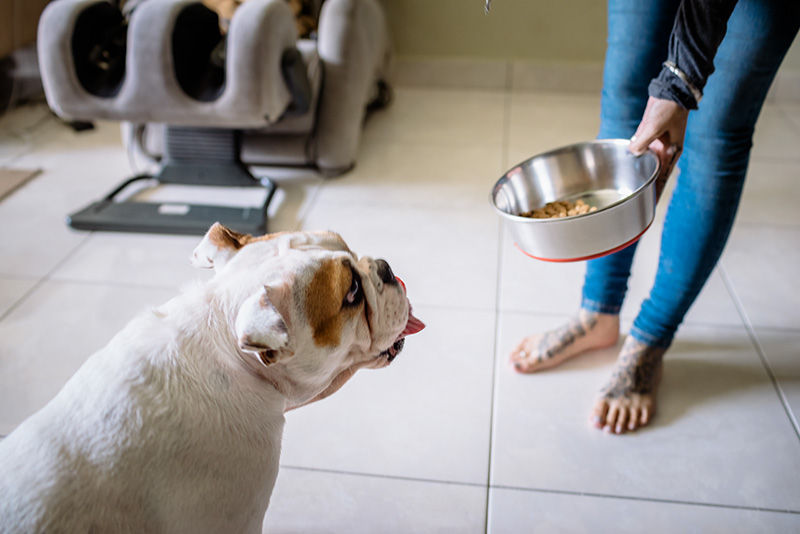

In [7]:
# eac_test_single.py
import torch
import torchvision.transforms as T
import torchvision.models as models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor
from tqdm import tqdm
import os
import cv2


# === Charger image de test ===
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image

In [8]:
# === Segmenter avec SAM ===
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [9]:
masks = mask_generator.generate(image)

Vérifier la segmentation de SAM

In [10]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [11]:
masks[1]['area']

186558

In [12]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

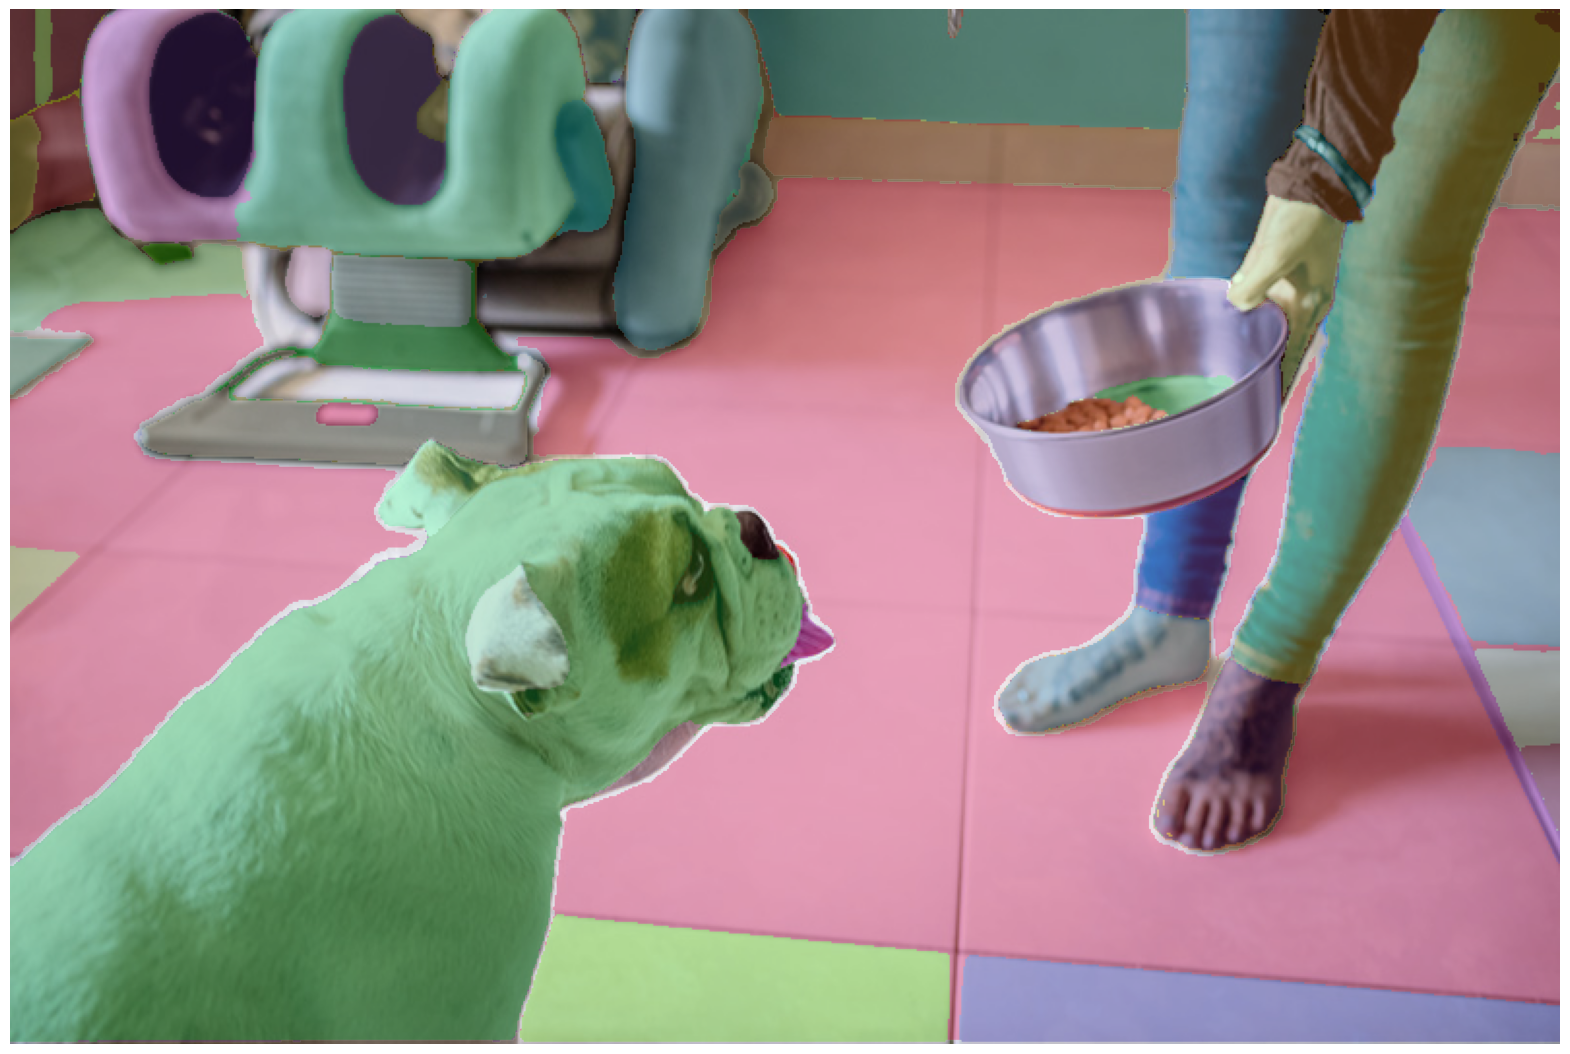

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

**Phase 2 : PIE**

Etape 3 : Charger modèle target Resnet-50

In [14]:
model = models.resnet50(pretrained=True)
model.eval()
model = model.to("cuda")
fc_layer = model.fc
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # sans FC

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Etape 3 : Mettre en place le Surrogate modèle

In [15]:
import torch.optim as optim

class SurrogateModel(torch.nn.Module):
    def __init__(self, fc_layer, num_concepts, feature_dim=2048, lr=0.008):
        super().__init__()
        self.h = torch.nn.Sequential(
            torch.nn.Linear(num_concepts, feature_dim),
            torch.nn.ReLU()
        )
        self.fc = fc_layer  # partagé avec ResNet

        # Freeze les paramètres
        for param in self.fc.parameters():
          param.requires_grad = False

        self.optimizer = optim.SGD(self.h.parameters(), lr=lr, momentum=0.9)

    def forward(self, b_onehot):
        features = self.h(b_onehot)
        return self.fc(features)

num_concepts = len(masks)
surrogate = SurrogateModel(fc_layer, num_concepts).to("cuda")
optimizer = torch.optim.Adam(surrogate.h.parameters(), lr=0.008)
loss_fn = torch.nn.CrossEntropyLoss()

Etape 5 : Créer le dataset d'entrainement du surrogate model = (image dont  certains concepts masqués, prédiction label du target model avec cette image masquée)

a CHANGER LE NOMBRE DE SAMPLE PAR 50 000 - Finalement, non (je crois pas précisé dans le papier)

In [16]:
import torchvision.transforms as transforms

# === créer les coalitions d’entraînement ===
def mask_image_from_concepts(concepts, concept_mask, image):
    """Masque tous les concepts sauf ceux activés dans concept_mask"""
    masked_img = image.copy()  # copie de l'image originale

    for i, mask in enumerate(concepts):
        if not concept_mask[i]:  # si le concept i doit être masqué
            masked_img[mask.astype(bool)] = 0

    masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1).float() / 255.

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )

    masked_img_tensor = normalize(masked_img_tensor)
    masked_img_tensor = masked_img_tensor.unsqueeze(0)

    return masked_img_tensor

samples = []
labels = []
concepts = [mask["segmentation"] for mask in masks]
for _ in tqdm(range(100),"création des images tronquées pour l'entrainement..."):
    mask_bin = np.random.randint(0, 2, size=(num_concepts,)) # c est un vecteur binaire [0 1 0 1 0 ...] : maskbin[5] = 0 = masque le cinquième concept
    x_masked = mask_image_from_concepts(concepts, mask_bin, image) # image originale masquée

    # get predictions of the target model
    with torch.no_grad():
        out = model(x_masked.to("cuda"))
        target = torch.argmax(out, dim=1).item()
    samples.append(torch.FloatTensor(mask_bin))
    labels.append(target)

samples_tensor = torch.stack(samples).to("cuda")
labels_tensor = torch.LongTensor(labels).to("cuda")

création des images tronquées pour l'entrainement...: 100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


Etape 6 : Train surrogate model with the dataset

In [17]:
# === Entraîner surrogate ===
from torch.utils.data import TensorDataset, DataLoader

# Création du DataLoader
batch_size = 32
dataset = TensorDataset(samples_tensor, labels_tensor)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Boucle d'entraînement batchée
for epoch in range(200):
    surrogate.train()
    total_loss = 0

    for xb, yb in loader:
        out = surrogate(xb)
        loss = loss_fn(out, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"--Epoch {epoch:03d} -- Loss: {avg_loss:.4f}")

--Epoch 000 -- Loss: 4.4757
--Epoch 001 -- Loss: 1.5746
--Epoch 002 -- Loss: 1.0275
--Epoch 003 -- Loss: 0.7856
--Epoch 004 -- Loss: 0.5804
--Epoch 005 -- Loss: 0.3834
--Epoch 006 -- Loss: 0.2207
--Epoch 007 -- Loss: 0.1494
--Epoch 008 -- Loss: 0.1317
--Epoch 009 -- Loss: 0.1189
--Epoch 010 -- Loss: 0.0787
--Epoch 011 -- Loss: 0.0665
--Epoch 012 -- Loss: 0.0473
--Epoch 013 -- Loss: 0.0385
--Epoch 014 -- Loss: 0.0313
--Epoch 015 -- Loss: 0.0275
--Epoch 016 -- Loss: 0.0248
--Epoch 017 -- Loss: 0.0251
--Epoch 018 -- Loss: 0.0209
--Epoch 019 -- Loss: 0.0187
--Epoch 020 -- Loss: 0.0183
--Epoch 021 -- Loss: 0.0156
--Epoch 022 -- Loss: 0.0155
--Epoch 023 -- Loss: 0.0148
--Epoch 024 -- Loss: 0.0131
--Epoch 025 -- Loss: 0.0126
--Epoch 026 -- Loss: 0.0126
--Epoch 027 -- Loss: 0.0117
--Epoch 028 -- Loss: 0.0109
--Epoch 029 -- Loss: 0.0106
--Epoch 030 -- Loss: 0.0103
--Epoch 031 -- Loss: 0.0096
--Epoch 032 -- Loss: 0.0093
--Epoch 033 -- Loss: 0.0089
--Epoch 034 -- Loss: 0.0086
--Epoch 035 -- Loss:

**Phase 3 : Concept based Explanation**

On utilise le PIE à la place du target modèl pour estimer les shapley values

Pour chaque concept calcule sa contribution : Monte Carlo sampling de coalitions

DANS PAPIER K = 50 000. Consomme trop de ressources, j'arrive pas à faire tourner sur GPU.

In [18]:
# === Approximation Shapley (MC sampling) ===
K = 5000
shapley_values = torch.zeros(num_concepts).to("cuda")

for i in tqdm(range(num_concepts),"approximation Shapley..."):
    for _ in range(K):
        if K % 100:
          print("Coalition ", K)
        S = torch.randint(0, 2, (num_concepts,), dtype=torch.float32).to("cuda")
        S[i] = 0
        S_with_ci = S.clone()
        S_with_ci[i] = 1

        pred_with_ci = surrogate(S_with_ci.unsqueeze(0)) # u(S) dans papier
        pred_without_ci = surrogate(S.unsqueeze(0)) # u(S without ci) dans le papier

        diff = pred_with_ci[0].max() - pred_without_ci[0].max()
        shapley_values[i] += diff

        del S_with_ci
        del S

shapley_values /= K

approximation Shapley...: 100%|██████████| 66/66 [02:59<00:00,  2.71s/it]


In [19]:
shapley_values

tensor([ 0.2590, -2.4430,  0.6582,  0.9194,  0.5350,  0.3070,  0.6960,  0.4633,
         0.1579,  0.4520,  0.0079,  0.6080,  0.8762,  0.4794,  0.3433,  0.3150,
         0.3283, -0.1096,  0.8104,  0.3538,  0.5522,  0.9288,  0.4032,  0.5080,
         0.5680,  0.0862,  0.6723,  0.7509,  0.1784,  0.5997,  0.8178,  0.2553,
         0.7021,  0.3502,  0.7108,  0.3239,  0.3922,  0.7601,  0.7369,  0.3220,
         0.9998,  0.4170,  0.5440,  0.7978,  0.9055, -0.0837,  0.7753,  0.3205,
         0.4595,  0.4243,  0.8782,  0.9372,  0.5521,  0.3698, -0.0512,  1.0089,
         0.5513,  0.4268,  0.4684,  0.4850,  0.1299,  0.5657,  0.2971,  0.3879,
         0.5482,  0.4950], device='cuda:0', grad_fn=<DivBackward0>)

J'ai choisi ensuite les 5 concepts avec la pls grandes valeurs de shapley (5 c'est arbitraire)

In [20]:
k = 5
_, topk_indices = torch.topk(shapley_values, k)
E = topk_indices
print("Top-k concepts contributing the most:", E.tolist())


Top-k concepts contributing the most: [55, 40, 51, 21, 3]


In [21]:
x = torch.from_numpy(image).permute(2, 0, 1).float() / 255.

# 2. Appliquer la normalisation ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
x = normalize(x)

# 3. Ajouter une dimension batch : [1, 3, H, W]
x = x.unsqueeze(0).to("cuda")

# 4. Prédire avec le modèle
with torch.no_grad():
    prediction = model(x)
    predicted_class = torch.argmax(prediction, dim=1).item()
    print("Classe prédite :", predicted_class)

Classe prédite : 171


In [22]:
import urllib.request

url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
imagenet_classes_path = "imagenet_classes.txt"
urllib.request.urlretrieve(url, imagenet_classes_path)
with open("imagenet_classes.txt") as f:
    classes = [line.strip() for line in f.readlines()]

predicted_idx = torch.argmax(prediction, dim=1).item()
print(f"Classe prédite : {predicted_idx} → {classes[predicted_idx]}")

Classe prédite : 171 → Italian greyhound


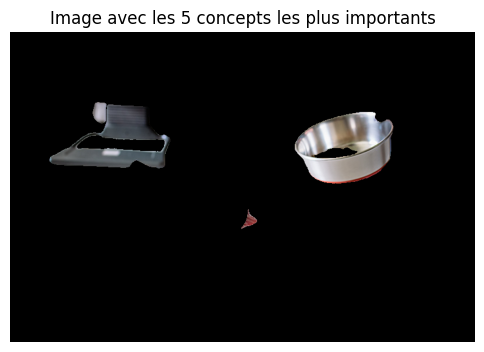

In [24]:
masked_img = image.copy()
masked_img[:, :, :] = 0

# Ajouter uniquement les pixels des concepts sélectionnés
for idx in E.tolist():
    mask = masks[idx]["segmentation"]
    for c in range(3):  # pour chaque canal RGB
        masked_img[:, :, c][mask] = image[:, :, c][mask]

# Affichage
plt.figure(figsize=(6, 6))
plt.imshow(masked_img)
plt.axis("off")
plt.title(f"Image avec les {len(E)} concepts les plus importants")
plt.show()

# **Evaluation metric**

**Faithfullness Evaluation**

In [27]:
from torchvision import transforms
def preprocess_image_for_model(img_np, device="cuda"):
    x = torch.from_numpy(img_np).permute(2, 0, 1).float() / 255.
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    x = normalize(x)
    return x.unsqueeze(0).to(device)

def insertion_scheme(model, image, concepts, sorted_indices, target_class, device="cuda"):
    h, w, c = image.shape
    insertion_mask = np.zeros((h, w), dtype=bool)
    insertion_vals = []

    for idx in sorted_indices:
        insertion_mask |= concepts[idx]
        img_copy = image.copy()
        for ch in range(3):
            img_copy[:, :, ch][~insertion_mask] = 0
        x = preprocess_image_for_model(img_copy, device)
        with torch.no_grad():
            prob = torch.softmax(model(x), dim=1)[0][target_class].item()
        insertion_vals.append(prob)

    return insertion_vals



def deletion_scheme(model, image, concepts, sorted_indices, target_class, device="cuda"):
    h, w, c = image.shape
    deletion_mask = np.ones((h, w), dtype=bool)
    deletion_vals = []

    for idx in sorted_indices:
        deletion_mask &= ~concepts[idx]
        img_copy = image.copy()
        for ch in range(3):
            img_copy[:, :, ch][~deletion_mask] = 0
        x = preprocess_image_for_model(img_copy, device)
        with torch.no_grad():
            prob = torch.softmax(model(x), dim=1)[0][target_class].item()
        deletion_vals.append(prob)

    return deletion_vals


def faithfulness_evaluation(model, image, concepts, shapley_values, device="cuda"):
    sorted_indices = torch.argsort(shapley_values, descending=True).tolist()

    x_full = preprocess_image_for_model(image, device)
    with torch.no_grad():
        pred = model(x_full)
        target_class = torch.argmax(pred, dim=1).item()

    insertion_vals = insertion_scheme(model, image, concepts, sorted_indices, target_class, device)
    deletion_vals = deletion_scheme(model, image, concepts, sorted_indices, target_class, device)

    x_axis = np.linspace(0, 1, len(insertion_vals))
    auc_ins = np.trapz(insertion_vals, x=x_axis)
    auc_del = np.trapz(1 - np.array(deletion_vals), x=x_axis)

    plt.figure(figsize=(10, 5))
    plt.plot(x_axis, insertion_vals, label="Insertion", color="green")
    plt.plot(x_axis, deletion_vals, label="Deletion", color="red")
    plt.xlabel("Ratio de concepts insérés/supprimés")
    plt.ylabel("Confiance du modèle")
    plt.title("Faithfulness Evaluation")
    plt.grid(True)
    plt.legend()
    plt.show()

    return auc_ins, auc_del




<ipython-input-27-1930647251>:58: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_ins = np.trapz(insertion_vals, x=x_axis)
<ipython-input-27-1930647251>:59: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_del = np.trapz(1 - np.array(deletion_vals), x=x_axis)


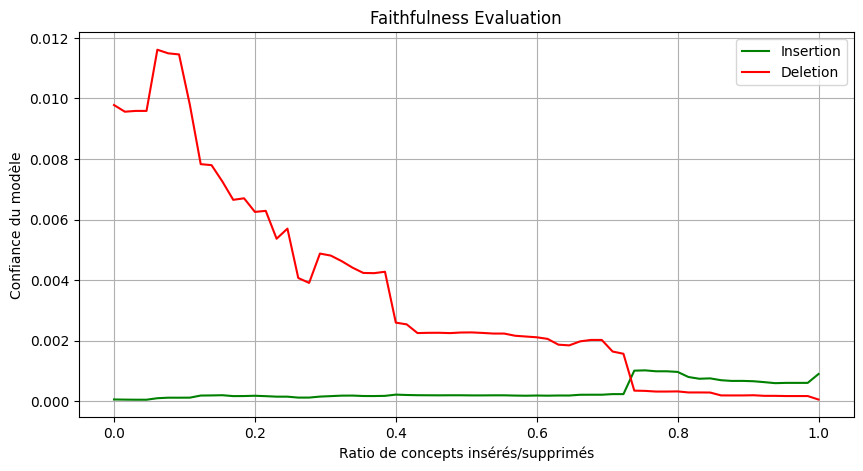

AUC Insertion: 0.0003
AUC Deletion : 0.9965


In [30]:
concepts = [m["segmentation"] for m in masks]
auc_insertion, auc_deletion = faithfulness_evaluation(model, image, concepts, shapley_values)
print(f"AUC Insertion: {auc_insertion:.4f}")
print(f"AUC Deletion : {auc_deletion:.4f}")

La confiance du modèle décroit fortement lorsqu'on enlève les concepts clés estimés par les valeurs de Shapley. Cela est encourageant : on identifie bien les concepts importants pour la détection.

Pour l'insertion scheme, on remarque que la confiance augmente trop peu. De toute façon, le modèle de base n'est pas très sûr de son résultat. A vrai dire il se trompe même, prenant ce bouledogue pour un lévrier italien, donc c'est assez logique que sa confiance soit faible dans sa réponse.

**Understandability**

Pour cette partie, il est vrai que les concepts observés ne semblent pas forcément les plus pertinents pour déterminer la classe de l'image. La gamelle est détecté ce qui est bien. Mais il ya des bouts de carrelage ou du meuble derrière qui ne sont pas utiles.

Comparaison avec le modèle du papier